**Kernel**
- [TimeSeries Analysis 📈 A Complete Guide 📚](https://www.kaggle.com/andreshg/timeseries-analysis-a-complete-guide)

**Dataset**
- [Acea Smart Water Analytics](https://www.kaggle.com/c/acea-water-prediction)

In [16]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings
warnings.filterwarnings('ignore')

np.random.seed(7)

**Table of Content**

- 1. Data visualization 📊
- 2. Data Preprocessing ⚙️
    - 2.1 Handle Missings
    - 2.2 Smoothing data / Resampling
    - 2.3 Stationarity
        - 2.3.1 Augmented Dickey-Fuller (ADF)
        - 2.3.2 Transforming
        - 2.3.3 Differencing
- 3. Feature engineering 🔧
    - 3.1 Encoding Cyclical Features
    - 3.2 TimeSeries Decomposition
    - 3.3 Lag
- 4. Exploratory Data Analysis 📊
    - 4.1 Autocorrelation Analysis
- 5. Modeling
    - 5.1 Models for Univariate Time Series
        - 5.1.1 Univariate Prophet
        - 5.1.2 ARIMA
        - 5.1.3 Auto-ARIMA
        - 5.1.4 LSTM
    - 5.2 Models for Multivariate Time Series
    - 5.2.1 Multivariate Prophet
- 6. Conclusions
- 7. References

In [17]:
df = pd.read_csv('data/Aquifer_Petrignano.csv')
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [18]:
# Remove old rows
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)

# Remove not usefull columns
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

In [19]:
# Simplify column names
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

targets = ['depth_to_groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [20]:
from datetime import datetime, date

df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


# Data visualization 📊

Features:

- **Rainfall** indicates the quantity of rain falling (mm)
- **Temperature** indicates the temperature (°C)
- **Volume**  indicates the volume of water taken from the drinking water treatment plant (m$^3$)
- **Hydrometry** indicates the groundwater level (m)

Target:

- **Depth to Groundwater** indicates the groundwater level (m from the ground floor)

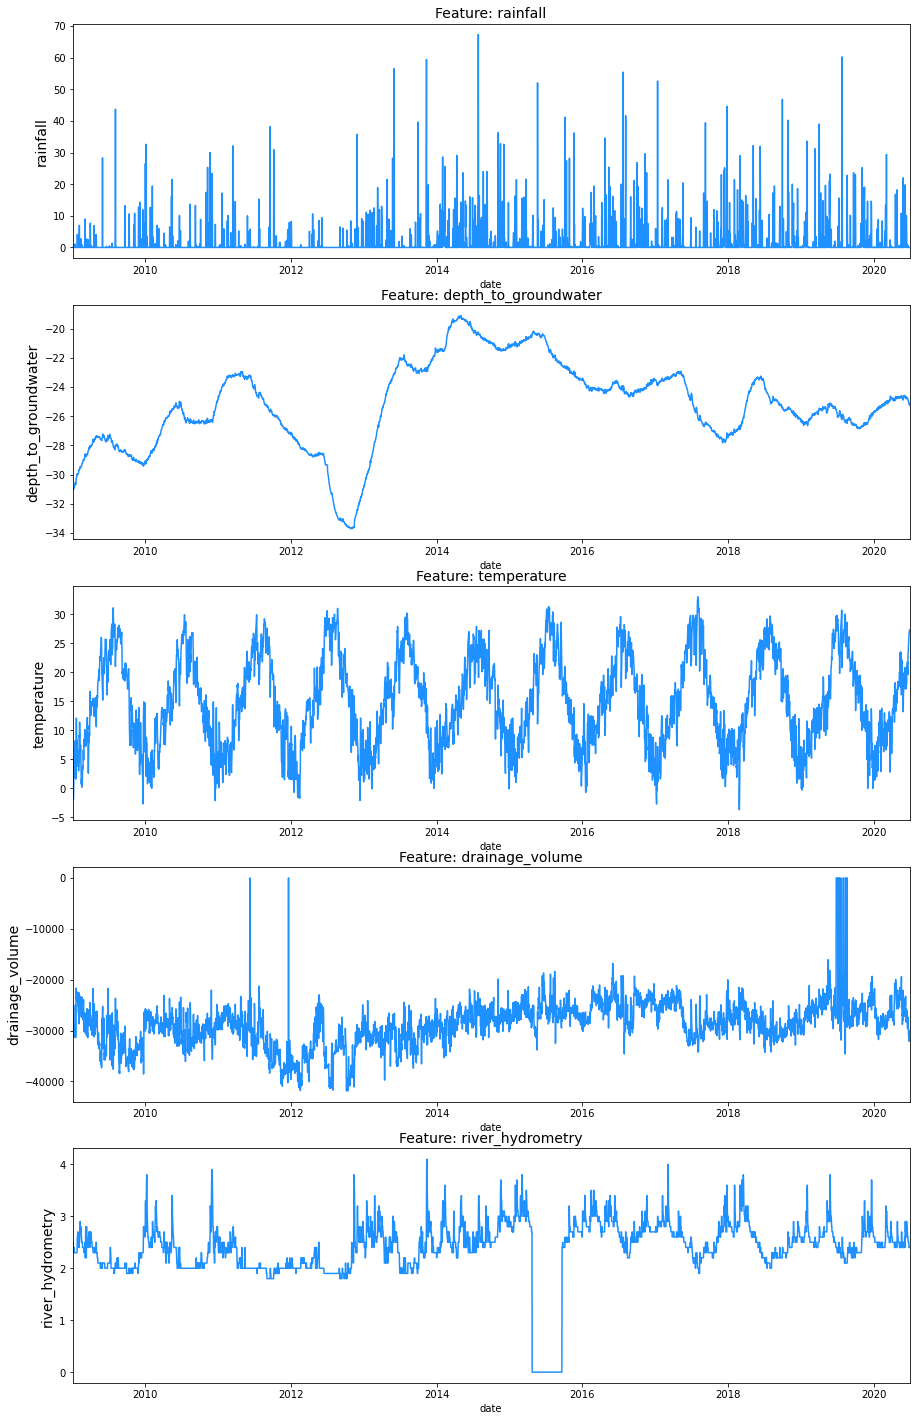

In [21]:
# To complete the data, as naive method, we will use ffill
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('date', axis=1).columns ):
    sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title(f'Feature: {column}', fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

# Data Preprocessing ⚙️ 

**Chronological Order and Equidistant Timestamps**
The data should be in chronological order and the timestamps should be equidistant in time series. The chronological order can be achieved by sorting the dataframe by the timestamps. Equidisant timestamps indicates constant time intervals. To check this, the difference between each timestamp can be taken. If this is not the case, you can decide on a constant time interval and resample the data.

But, first of all, lets see how to check if our dataset is correctly formated!


In [22]:
df = df.sort_values(by='date')

# Check time intervals
df['delta'] = df['date'] - df['date'].shift(1)

df[['date', 'delta']].head()

,date,delta
0,2009-01-01,NaT
1,2009-01-02,1 days
2,2009-01-03,1 days
3,2009-01-04,1 days
4,2009-01-05,1 days


In [23]:
df['delta'].sum(), df['delta'].count()

(Timedelta('4198 days 00:00:00'), 4198)

## Handle Missings

데이터셋에 null 값이 있습니다.

또한 drainage_volume 와 river_hydrometry 에는 null인 것 같은 값이 0으로 표시된 것으로 보입니다. 이는 nan값으로 교체한 후 다시 채워야 합니다.

In [24]:
df = df.drop('delta', axis=1)
df.isna().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

(14245.0, 18443.0)

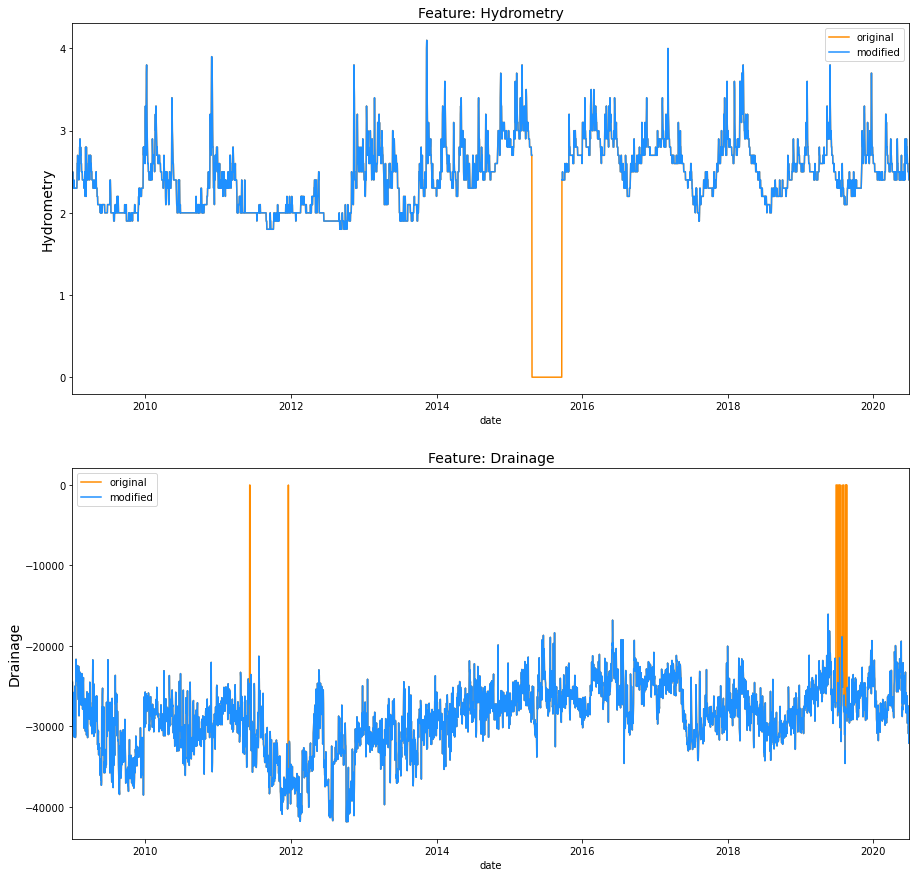

In [25]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

old_hydrometry = df['river_hydrometry'].copy()
df['river_hydrometry'] = df['river_hydrometry'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_hydrometry, ax=ax[0], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['river_hydrometry'].fillna(np.inf), ax=ax[0], color='dodgerblue', label='modified')
ax[0].set_title('Feature: Hydrometry', fontsize=14)
ax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

old_drainage = df['drainage_volume'].copy()
df['drainage_volume'] = df['drainage_volume'].replace(0, np.nan)

sns.lineplot(x=df['date'], y=old_drainage, ax=ax[1], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label='modified')
ax[1].set_title('Feature: Drainage', fontsize=14)
ax[1].set_ylabel(ylabel='Drainage', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

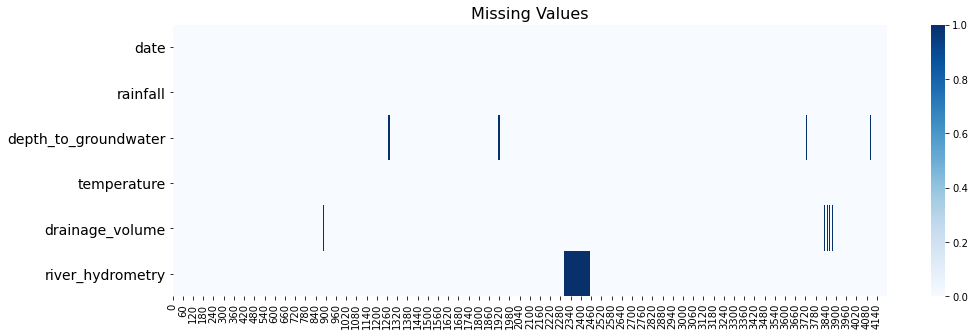

In [26]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))

sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Missing Values', fontsize=16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

### Missing Values, how to handle
- **Option 1: Fill NaN with Outlier or Zero**

In this specific example filling the missing value with an outlier value such as np.inf or 0 seems to be very naive. However, using values like -999, is sometimes a good idea.

- **Option 2: Fill NaN with Mean Value**

Filling NaNs with the mean value is also not sufficient and naive, and doesn't seems to be a good option.

- **Option 3: Fill NaN with Last Value with .ffill()**

Filling NaNs with the last value could be bit better.

- **Option 4: Fill NaN with Linearly Interpolated Value with .interpolate()**

Filling NaNs with the interpolated values is the best option in this small examlple but it requires knowledge of the neighouring value

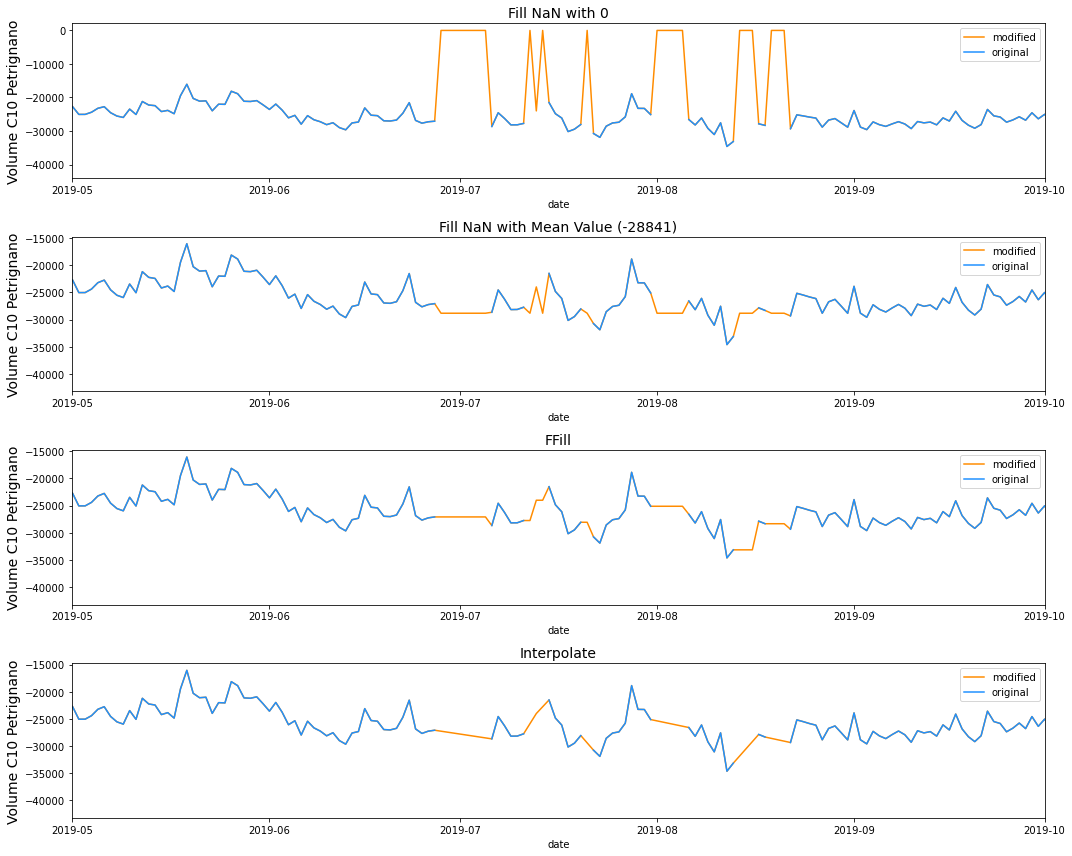

In [30]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(0), ax=ax[0], color='darkorange', label='modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[0], color='dodgerblue', label='original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

mean_drainage = df['drainage_volume'].mean()
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(mean_drainage), ax=ax[1], color='darkorange', label='modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label='original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_drainage:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].ffill(), ax=ax[2], color='darkorange', label='modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[2], color='dodgerblue', label='original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].interpolate(), ax=ax[3], color='darkorange', label='modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[3], color='dodgerblue', label='original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])

plt.tight_layout()
plt.show()

In [31]:
df['drainage_volume'] = df['drainage_volume'].interpolate()
df['river_hydrometry'] = df['river_hydrometry'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()